## Parsing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, MiniBatchKMeans
from sklearn.decomposition import  PCA
import os

In [2]:
def loadData(filePath):
    with open(filePath) as f:
        data = f.read().split('\n')
    elements = []
    for line in data:
        el = line.split()
        try:
            elements.append([el[0],el[4], ' '.join(el[7:])])
        except:
            pass
    
    #Build Dataframe
    df = pd.DataFrame(elements, columns=['timestamp','AP','message'])
    df.drop_duplicates(inplace=True)
    
    df['Disassociating'] = df.message.str.extract(r'Disassociating (\w+)', expand=False)
    df['Station'] = df.message.str.extract(r'Station (\w+)', expand=False)
    df['Action'] = df.message.str.extract(r'Station \w+ (\w+)', expand=False)
    
    df.ix[ ~ df.Disassociating.isnull(),'Station'] = df.ix[ ~ df.Disassociating.isnull(),'Disassociating']
    df.ix[ ~ df.Disassociating.isnull(),'Action'] = 'Disassociating'
    
    df['Deauthenticating'] = df.message.str.extract(r'Deauthenticating (\w+)', expand=False)
    df.ix[ ~ df.Deauthenticating.isnull(),'Station'] = df.ix[ ~ df.Deauthenticating.isnull(),'Deauthenticating']
    df.ix[ ~ df.Deauthenticating.isnull(),'Action'] = 'Deauthenticating'
    
    df.drop(['Disassociating','Deauthenticating'], axis=1, inplace=True)
    
    
    df['BuildingType'] = df.AP.str.extract(r'(\w+)Bldg', expand=False)
    df['BuildingNumber'] = df.AP.str.extract(r'Bldg(\d+)', expand=False)
    df['APnumber'] = df.AP.str.extract(r'AP(\d+)', expand=False)
    df['BuildingId'] = df.BuildingType + df.BuildingNumber
    return df

In [3]:
def parsingLogs(fileFolder):
    paths = [x for x in os.listdir(fileFolder) if x.endswith('.log') ]
    paths = [os.path.join(fileFolder,x) for x in paths]
    
    # create dataframe
    df = pd.DataFrame()
    
    #append
    for p in paths:
        df = df.append(loadData(p))
    
    #Linking stations and Aps
    df.ix[ ~df.Station.isnull(), 'Ap_Station_Link'] = 1
    
    #transform index
    df['timestamp'] = pd.to_datetime(df.timestamp, unit='s')
    df.index = df.timestamp
    
    return df

In [72]:
df = parsingLogs("syslog-v3.3/")

In [73]:
df.tail()

,timestamp,AP,message,Station,Action,BuildingType,BuildingNumber,APnumber,BuildingId,Ap_Station_Link
timestamp,,,,,,,,,,
2001-05-11 03:59:47,2001-05-11 03:59:47,AcadBldg10AP22,Station 00409620586b Authenticated,00409620586b,Authenticated,Acad,10,22,Acad10,1.0
2001-05-11 03:59:49,2001-05-11 03:59:49,AcadBldg10AP4,Station 00409620586b Authenticated,00409620586b,Authenticated,Acad,10,4,Acad10,1.0
2001-05-11 03:59:51,2001-05-11 03:59:51,AcadBldg10AP8,Station 00409620586b Authenticated,00409620586b,Authenticated,Acad,10,8,Acad10,1.0
2001-05-11 03:59:56,2001-05-11 03:59:56,AcadBldg10AP14,Station 00409620586b Authenticated,00409620586b,Authenticated,Acad,10,14,Acad10,1.0
2001-05-11 03:59:58,2001-05-11 03:59:58,AcadBldg10AP9,Station 00409620586b Authenticated,00409620586b,Authenticated,Acad,10,9,Acad10,1.0


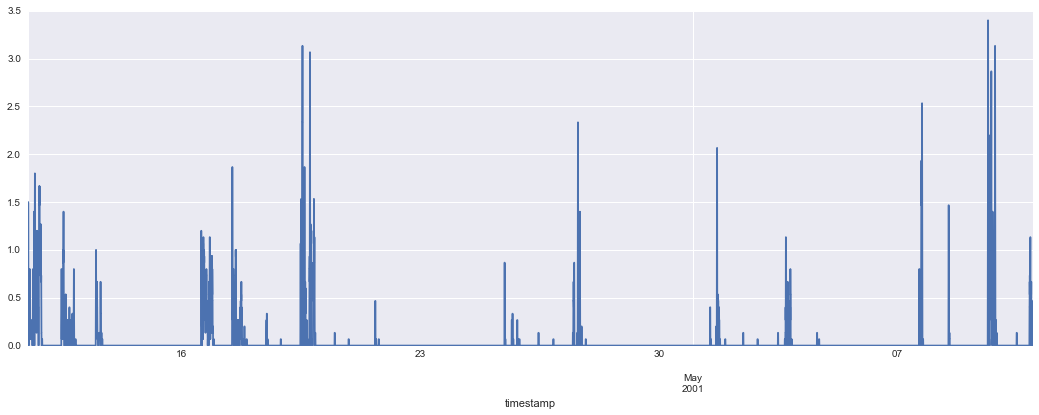

In [74]:
plt.figure(figsize=(18,6))
a = df.ix[df.Station=='0040961e58be'].Ap_Station_Link.resample('1Min').sum().fillna(0)
a.rolling('15Min').mean().plot()
plt.show()

## Activities per stations

In [75]:
def splitPerBuilding(df):
    #station list
    stations = list(set(df.ix[~df.Station.isnull(),'Station']))
    
    #building list
    bldg = list(set(df.BuildingType))
    bldg.sort()
    
    #list of dataframes
    building_list = []
    for i,buld in enumerate(bldg):
        building_list.append(pd.DataFrame())

        building_list[i]['all'] = df.Ap_Station_Link.resample('1Min').sum().fillna(0).rolling('15Min').mean()    
        for s in stations:
            a = df.ix[np.asarray(df.BuildingType == buld) & np.asarray(df.Station == s)].Ap_Station_Link.resample('1Min').sum().fillna(0)
            b = df.ix[np.asarray(df.BuildingType == buld) & np.asarray(df.Station == s)].APnumber.resample('1Min').count().fillna(0)
            c = a/b  # normalize by the number of APs connected to
            building_list[i][s] = c.fillna(0).rolling('15Min').median()
        building_list[i].fillna(0, inplace=True)
        building_list[i].drop('all', 1, inplace=True)
    
    return building_list, bldg

In [76]:
building_list, bldg = splitPerBuilding(df)

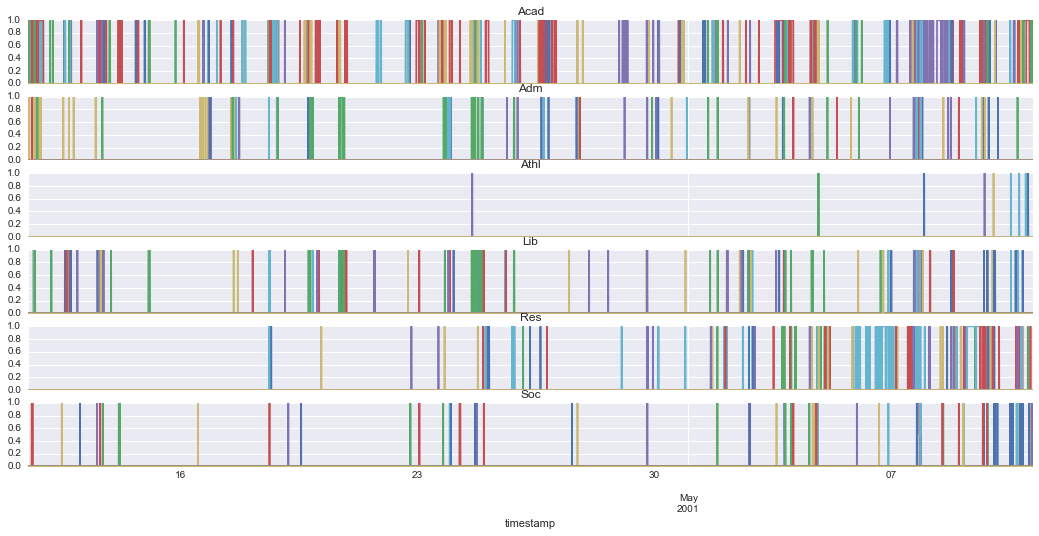

In [79]:
fig, axes = plt.subplots(nrows=len(building_list), ncols=1)
for i,b in enumerate(building_list):
    b.plot(ax=axes[i],figsize=(18,8), legend=False, kind='line', sharex=True)
    axes[i].set_title(bldg[i])
    
plt.show()

## Clustering the stations

We can group the stations accordinglly to the time spent on the different buildings.

In [80]:
def timeSpendBuildings(building_list, bldg):
    r = len(building_list[0].columns)
    c = len(bldg)
    # emplty matrice
    l = pd.DataFrame([x.sum() for x in building_list])
    #normalize the time for each station
    df = (l / l.sum()).T
    
    df.columns=bldg
    return df

In [81]:
time_spent_buildings = timeSpendBuildings(building_list, bldg)

In [82]:
from sklearn.cluster import DBSCAN

In [83]:
db = DBSCAN().fit(cosine_similarity(time_spent_buildings))

In [84]:
db.labels_

array([ 0, -1,  1, -1, -1, -1, -1,  2,  2,  2, -1, -1,  1, -1,  0,  1,  3,
        2, -1,  2,  2,  0, -1, -1, -1,  3,  2,  2, -1,  2, -1,  1,  3, -1,
        4,  2,  1,  2,  2,  2,  2, -1,  1, -1, -1,  3,  0,  2, -1,  1,  2,
       -1, -1, -1, -1, -1, -1,  2, -1,  2, -1, -1,  2, -1, -1,  2, -1,  3,
        2, -1, -1, -1, -1,  2,  2, -1, -1, -1, -1,  2,  2,  2,  4,  2,  2,
       -1, -1, -1, -1, -1,  3, -1, -1,  2, -1,  2, -1,  2,  2, -1,  3, -1,
       -1,  2, -1,  2,  2,  2, -1, -1,  2, -1,  1, -1,  2, -1, -1,  2, -1,
        2,  0, -1, -1,  2,  4,  2, -1, -1,  2,  4, -1,  1,  2, -1,  1, -1,
        2, -1, -1,  2,  1, -1, -1,  1, -1,  2, -1, -1, -1, -1, -1, -1, -1,
        3,  2, -1, -1, -1,  2, -1, -1, -1,  2,  2,  3,  0,  2,  2, -1, -1,
       -1,  3,  2, -1,  0, -1,  1,  2, -1,  2,  1,  4,  2,  2,  2,  3,  2,
        1,  2, -1, -1,  1,  3,  2, -1,  2,  2, -1, -1,  2, -1, -1, -1], dtype=int64)

In [85]:
mat = time_spent_buildings.copy()
mat['db_labels'] = db.labels_
mat.sort_values('db_labels', inplace=True)
mat

,Acad,Adm,Athl,Lib,Res,Soc,db_labels
003065fb6bb0,0.157895,0.157895,0.157895,0.157895,0.368421,0.000000,-1
00409653f0d3,0.313953,0.034884,0.000000,0.220930,0.162791,0.267442,-1
00022d3ae59b,0.571429,0.000000,0.000000,0.000000,0.428571,0.000000,-1
0040966fb204,0.566893,0.000000,0.000000,0.312925,0.000000,0.120181,-1
004096011ce9,0.250000,0.000000,0.000000,0.250000,0.250000,0.250000,-1
0030654806d7,0.428571,0.000000,0.000000,0.142857,0.285714,0.142857,-1
003065fc1494,0.250000,0.250000,0.000000,0.250000,0.000000,0.250000,-1
00409649fe8d,0.669903,0.330097,0.000000,0.000000,0.000000,0.000000,-1
003065e2d2b5,0.042254,0.000000,0.042254,0.211268,0.436620,0.267606,-1
00601d70421b,0.230769,0.230769,0.000000,0.000000,0.000000,0.538462,-1


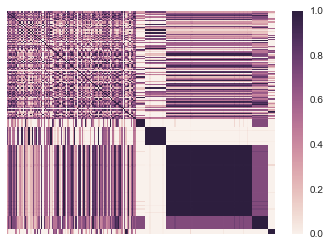

In [90]:
sns.heatmap(cosine_similarity(mat[mat.columns.difference(['db_labels'] )].as_matrix()),xticklabels=False, yticklabels=False)
plt.show()

In [87]:
pca = PCA(n_components=2)
mat_red = pd.DataFrame(pca.fit_transform(mat.iloc[:,:3].as_matrix()))

In [88]:
mat_red['label'] = mat.db_labels.as_matrix()

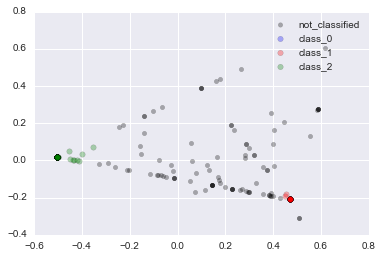

In [89]:
plt.scatter(mat_red.ix[mat_red.label == -1, 0], mat_red.ix[mat_red.label == -1, 1], label="not_classified", c='black', alpha=.3)
plt.scatter(mat_red.ix[mat_red.label == 0, 0], mat_red.ix[mat_red.label == 0, 1], label="class_0", c='blue', alpha=.3, s=30)
plt.scatter(mat_red.ix[mat_red.label == 1, 0], mat_red.ix[mat_red.label == 1, 1], label="class_1", c='red', alpha=.3 , s=30)
plt.scatter(mat_red.ix[mat_red.label == 2, 0], mat_red.ix[mat_red.label == 2, 1], label="class_2", c='green', alpha=.3, s=30)
plt.legend(loc='best')
plt.show()

In [106]:
cl = list(set(mat_red.label))

In [107]:
from matplotlib.pyplot import cm
color=iter(cm.rainbow(np.linspace(0,1,len(cl))))

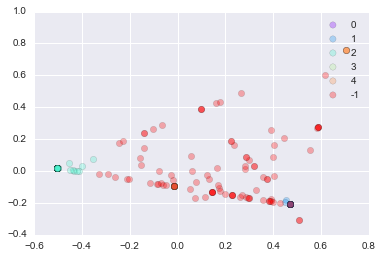

In [108]:
for i, m in enumerate(cl):
    plt.scatter(mat_red.ix[mat_red.label == m, 0], mat_red.ix[mat_red.label == m, 1], label=cl[i] , c=next(color), alpha=.3, s=40)
plt.legend(loc='best')
plt.show()